# Objective: fine-tuning DETR with the view-of-delft dataset

![DETR](detr/.github/DETR.png)

-   Parts of this notebook are based on: https://github.com/woctezuma/finetune-detr
-   Official DETR repository: https://github.com/facebookresearch/detr
-   Discussion about fine-tuning in [a GitHub issue](https://github.com/facebookresearch/detr/issues/9).
-   The View of Delft Dataset: https://github.com/tudelft-iv/view-of-delft-dataset

## Define useful boilerplate functions

Adapted from:
-   https://colab.research.google.com/github/facebookresearch/detr/blob/colab/notebooks/detr_attention.ipynb

In [1]:
import torch, torchvision
print(torch.__version__, torch.cuda.is_available())
print(f'Found {torch.cuda.device_count()} GPU(s) available')
for device in range(torch.cuda.device_count()):
    print(torch.cuda.get_device_name(device))

torch.set_grad_enabled(False);

2.2.1+cu118 True
Found 1 GPU(s) available
NVIDIA GeForce RTX 3080


In [2]:
import torchvision.transforms as T

# standard PyTorch mean-std input image normalization
transform = T.Compose([
    T.Resize(800),
    T.ToTensor(),
    T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# for output bounding box post-processing
def box_cxcywh_to_xyxy(x):
    x_c, y_c, w, h = x.unbind(1)
    b = [(x_c - 0.5 * w), (y_c - 0.5 * h),
         (x_c + 0.5 * w), (y_c + 0.5 * h)]
    return torch.stack(b, dim=1)

def rescale_bboxes(out_bbox, size):
    img_w, img_h = size
    b = box_cxcywh_to_xyxy(out_bbox)
    b = b * torch.tensor([img_w, img_h, img_w, img_h], dtype=torch.float32)
    return b

In [3]:
def filter_bboxes_from_outputs(outputs, threshold=0.7):

  # keep only predictions with confidence above threshold
  probas = outputs['pred_logits'].softmax(-1)[0, :, :-1]
  keep = probas.max(-1).values > threshold

  probas_to_keep = probas[keep]

  # convert boxes from [0; 1] to image scales
  bboxes_scaled = rescale_bboxes(outputs['pred_boxes'][0, keep], im.size)

  return probas_to_keep, bboxes_scaled

In [4]:
# COCO classes
CLASSES = [
    'N/A', 'person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus',
    'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'N/A',
    'stop sign', 'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse',
    'sheep', 'cow', 'elephant', 'bear', 'zebra', 'giraffe', 'N/A', 'backpack',
    'umbrella', 'N/A', 'N/A', 'handbag', 'tie', 'suitcase', 'frisbee', 'skis',
    'snowboard', 'sports ball', 'kite', 'baseball bat', 'baseball glove',
    'skateboard', 'surfboard', 'tennis racket', 'bottle', 'N/A', 'wine glass',
    'cup', 'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple', 'sandwich',
    'orange', 'broccoli', 'carrot', 'hot dog', 'pizza', 'donut', 'cake',
    'chair', 'couch', 'potted plant', 'bed', 'N/A', 'dining table', 'N/A',
    'N/A', 'toilet', 'N/A', 'tv', 'laptop', 'mouse', 'remote', 'keyboard',
    'cell phone', 'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'N/A',
    'book', 'clock', 'vase', 'scissors', 'teddy bear', 'hair drier',
    'toothbrush'
]

# colors for visualization
COLORS = [[0.000, 0.447, 0.741], [0.850, 0.325, 0.098], [0.929, 0.694, 0.125],
          [0.494, 0.184, 0.556], [0.466, 0.674, 0.188], [0.301, 0.745, 0.933]]

In [5]:
import matplotlib.pyplot as plt

def plot_results(pil_img, prob=None, boxes=None):
    plt.figure(figsize=(16,10))
    plt.imshow(pil_img)
    ax = plt.gca()
    colors = COLORS * 100
    if prob is not None and boxes is not None:
      for p, (xmin, ymin, xmax, ymax), c in zip(prob, boxes.tolist(), colors):
          ax.add_patch(plt.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin,
                                    fill=False, color=c, linewidth=3))
          cl = p.argmax()
          text = f'{CLASSES[cl]}: {p[cl]:0.2f}'
          ax.text(xmin, ymin, text, fontsize=15,
                  bbox=dict(facecolor='yellow', alpha=0.5))
    plt.axis('off')
    plt.show()

## Demonstration of the base model with an image

In [ ]:
model = torch.hub.load('facebookresearch/detr', 'detr_resnet50', pretrained=True)
model.eval();

In [ ]:
from PIL import Image
import requests

url = 'http://images.cocodataset.org/train2017/000000310645.jpg'
im = Image.open(requests.get(url, stream=True).raw)

In [ ]:
# mean-std normalize the input image (batch-size: 1)
img = transform(im).unsqueeze(0)

# propagate through the model
outputs = model(img)

In [ ]:
for threshold in [0.9, 0.7, 0.0]:
  probas_to_keep, bboxes_scaled = filter_bboxes_from_outputs(outputs, threshold=threshold)
  plot_results(im, probas_to_keep, bboxes_scaled)

## Custom code for DETR

Adapted [Detr fork](https://github.com/woctezuma/detr/tree/finetune) for a custom dataset:
-   called `custom`,
-   with `max_class_id` ([explanation](https://github.com/facebookresearch/detr/issues/108#issuecomment-650269223)).

**Important**: if you later use `first_class_index = 1` for your dataset, then it is fine. However, if you later use `first_class_index = 0`, then you will have to override the value of `max_class_id` (so that it is equal to 1) when calling `!python main.py`.


In [6]:
path = "/home/matthijs/Documents/study/CS4245_Vision"

%cd $path

#!rm -rf detr
#!git clone https://github.com/woctezuma/detr.git
#!git clone https://github.com/DepthAwareObjectDetection/detr.git

%cd detr/

#!git checkout finetune

/home/matthijs/Documents/study/CS4245_Vision
/home/matthijs/Documents/study/CS4245_Vision/detr


/home/matthijs/.local/lib/python3.10/site-packages/IPython/core/magics/osm.py:417: UserWarning: using dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


## Prepair pre-trained model without class weights

Load a check-point model (urls can be found [here](https://github.com/facebookresearch/detr#model-zoo)). Remove the classification head to be fine-tuned.

In [87]:
# Get pretrained weights
# startpoint = torch.hub.load_state_dict_from_url(
#             url='https://dl.fbaipublicfiles.com/detr/detr-r50-e632da11.pth',
#             map_location='cpu',
#             check_hash=True)

startpoint = torch.hub.load('facebookresearch/detr:main', 'detr_resnet50', pretrained=True).state_dict()

shapeconv = torch.load('outputs-low-lr-shape-conv/checkpoint.pth', map_location='cpu')

for key, value in shapeconv["model"].items() :
    if key in startpoint:
        if value.shape == startpoint[key].shape:
            if 'transformer' in key:
                shapeconv["model"][key] = startpoint[key].clone()

# for key, value in shapeconv["model"].items() :
#     if key in startpoint:
#         if torch.all(value.eq(startpoint[key])):
#             print(f'Key equal: {key}')
                  
# Remove class weights
# del startpoint["model"]["class_embed.weight"]
# del startpoint["model"]["class_embed.bias"]

# Save
torch.save(shapeconv, 'shape-conv-tr-r50_no-class-head.pth')

Using cache found in /home/matthijs/.cache/torch/hub/facebookresearch_detr_main


## Prepare the VOD dataset for fine-tuning

The `view-of-delft` dataset will be used to finetune the model. It is documented here:
-   https://github.com/tudelft-iv/view-of-delft-dataset

The dataset uses the KITTI annotation format. Since DETR expects COCO annotations we need to convert the annotations and move them into the correct folders.

Choose whether to start indexing categories/ids with 0 or with 1.

This is a matter of taste, and it should not impact the performance of the algorithm.

In [7]:
# Choose whether to start indexing categories with 0 or with 1.
# NB: convention in COCO dataset is such that the 1st class (person) has ID n°1.
# NB²: this is why we chose to set to 1 the default value of `first_class_index`
# in `via2coco.convert()`.

first_class_index = 0

Set the KITTI_CLASSES and corresponding COCO classes

In [8]:
import os
import json
import datetime
import shutil

# Constants and mappings
KITTI = 'kitti'
COCO = 'coco'

# Mapping KITTI classes to COCO format
KITTI_CLASSES = {
    'bicycle': 0,
    'Car': 1,
    'motor': 2,
    'Pedestrian': 3,
    'truck': 4,
    'ride_other': 5,
    'Cyclist': 6,
    'moped_scooter': 7,
    'rider': 8,
    'bicycle_rack': 9,
    'vehicle_other': 10,
    'ride_uncertain': 11,
    'DontCare': 12,
    'human_depiction': 13
}

KITTI2COCO = {
    0: (first_class_index, 'bicycle', 'vehicle'),
    1: (first_class_index + 1, 'car', 'vehicle'),
    2: (first_class_index + 2, 'motorcycle', 'vehicle'),
    3: (first_class_index + 3, 'person', 'person'),
    4: (first_class_index + 4, 'truck', 'vehicle')
}


def get_files(directory):
    return [f for f in os.listdir(directory) if os.path.isfile(os.path.join(directory, f))]


def filename_to_id(filename, dataset_type):
    # Implement a way to convert filenames to unique IDs
    return int(os.path.splitext(filename)[0])

Custom function to convert the `.txt` KITTI files to `.json` COCO format

In [ ]:
def convert_kitti_to_coco(source_dir, target_dir, filename='kitti_to_coco_annotations'):
    """Convert KITTI label files to COCO label file
    source_dir: directory of KITTI label files
    target_dir: directory COCO label file is created"""
    files = get_files(source_dir)
    os.makedirs(target_dir, exist_ok=True)
    write_file = os.path.join(target_dir, f'{filename}.json')
    ann_counter = 0  # annotations counter
    now = datetime.datetime.now()
    body = {
        "info": {
            "year": now.year,
            "version": "0.0",
            "description": "Annotations converted from KITTI to COCO format",
            "contributor": "Unknown",
            "url": "",
            "date_created": str(now)
        },
        "images": [],
        "annotations": [],
        "categories": [],
        "licenses": [{"id": 0, "name": "None", "url": ""}],
    }
    images_array = []
    annotations_array = []
    file_counter = 0
    for file_counter, file_name in enumerate(files):
        # print('{}: {} of {}'.format(file_name, file_counter + 1, len(files)))
        if not file_name.lower().endswith('.txt'):
            print(f'Skipping {file_name}')
            continue

        img_file_name = os.path.splitext(file_name)[0] + ".npy"
        read_file = os.path.join(source_dir, file_name)

        with open(read_file, 'r') as rf:
            file_id = filename_to_id(file_name, 'kitti')
            width = 1936
            height = 1216
            file_item = {
                "id": file_id,
                "width": width,
                "height": height,
                "file_name": img_file_name,
                "license": 0,
                "flickr_url": "",
                "coco_url": "",
                "date_captured": str(now),
            }

            images_array.append(file_item)

            for line in rf:
                str_array = line.split()
                class_name = str_array[0]
                if class_name not in KITTI_CLASSES:
                    print(f'Class: {class_name} not found in KITTI_CLASSES')
                    continue
                if KITTI_CLASSES[class_name] not in KITTI2COCO:
                    continue
                category_id = KITTI2COCO[KITTI_CLASSES[class_name]][0]
                ann_counter += 1
                x1 = str_array[4]
                y1 = str_array[5]
                x2 = str_array[6]
                y2 = str_array[7]
                x = float(x1)
                y = float(y1)
                width = round(float(x2) - x, 2)
                height = round(float(y2) - y, 2)
                area = round(width * height, 2)
                annotation = {
                    "id": ann_counter,
                    "image_id": file_id,
                    "category_id": category_id,
                    "segmentation": [],
                    "area": area,
                    "bbox": [x, y, width, height],
                    "iscrowd": 0,
                }
                annotations_array.append(annotation)

    print(f"Converted {file_counter} KITTI label files to COCO label files")

    categories = []
    for idx in KITTI2COCO:
        categories.append({
            "id": KITTI2COCO[idx][0],
            "name": KITTI2COCO[idx][1],
            "supercategory": KITTI2COCO[idx][2],
        })

    body["images"] = images_array
    body["annotations"] = annotations_array
    body["categories"] = categories

    with open(write_file, 'w') as wf:
        wf.write(json.dumps(body, indent=4))
    return write_file

Function to split the View-of-Delft dataset in train and val folders

In [ ]:
# Function to copy files based on the numbers in txt file
def copy_files(source_dir, txt_path, dest_dir, filetype=".jpg"):
    os.makedirs(dest_dir, exist_ok=True)
    with open(txt_path, 'r') as file:
        for line in file:
            image_number = line.strip()
            image_name = f"{image_number}{filetype}"
            source_image_path = os.path.join(source_dir, image_name)
            dest_image_path = os.path.join(dest_dir, image_name)

            if os.path.exists(source_image_path):
                shutil.copy(source_image_path, dest_image_path)
                # print(f"Copied {image_name} to {dest_dir}")
            else:
                print(f"Image {image_name} does not exist in {source_dir}")

# Function to create symbolic links based on the numbers in the txt file
def link_files(source_dir, txt_path, dest_dir, filetype=".jpg"):
    os.makedirs(dest_dir, exist_ok=True)
    with open(txt_path, 'r') as file:
        for line in file:
            image_number = line.strip()
            image_name = f"{image_number}{filetype}"
            source_image_path = os.path.join(source_dir, image_name)
            dest_image_path = os.path.join(dest_dir, image_name)

            if os.path.exists(source_image_path):
                if not os.path.exists(dest_image_path):  # Avoid overwriting existing links
                    os.symlink(source_image_path, dest_image_path)
                    # print(f"Linked {image_name} to {dest_dir}")
                else:
                    print(f"Link for {image_name} already exists in {dest_dir}")
            else:
                print(f"Image {image_name} does not exist in {source_dir}")

Perform transformation of KITTI to COCO annotation format

In [9]:
# Define paths
dataset_dir = f'{path}/view-of-delft-dataset'                       # VOD
base_dir = os.path.join(dataset_dir, 'lidar')                       # VOD/lidar
image_sets_dir = os.path.join(base_dir, 'ImageSets')                # VOD/lidar/ImageSets
training_image_dir = os.path.join(base_dir, 'training', 'image_depth_2')  # VOD/lidar/training/image_2
training_label_dir = os.path.join(base_dir, 'training', 'label_2')  # VOD/lidar/training/label_2

train_txt_path = os.path.join(image_sets_dir, 'train.txt')          # VOD/lidar/ImageSets/train.txt
val_txt_path = os.path.join(image_sets_dir, 'val.txt')              # VOD/lidar/ImageSets/val.txt
test_txt_path = os.path.join(image_sets_dir, 'test.txt')            # VOD/lidar/ImageSets/test.txt

train_image_dir = os.path.join(base_dir, 'training', 'image_depth_2_train')   # VOD/lidar/training/image_2_train
val_image_dir = os.path.join(base_dir, 'training', 'image_depth_2_val')       # VOD/lidar/training/image_2_val

train_label_dir = os.path.join(base_dir, 'training', 'label_2_train')   # VOD/lidar/training/label_2_train
val_label_dir = os.path.join(base_dir, 'training', 'label_2_val')       # VOD/lidar/training/label_2_val

# source_dir = os.path.join(dataset_dir, 'lidar/training/label_2')          # VOD/lidar/training/label_2
coco_label_dir = os.path.join(dataset_dir, 'lidar/training/label_2_coco')   # VOD/lidar/training/label_2_coco

In [ ]:
# Copy train files
link_files(training_image_dir, train_txt_path, train_image_dir, filetype=".npy")    # Train images
copy_files(training_label_dir, train_txt_path, train_label_dir, filetype=".txt")    # Train labels

# Copy val files
link_files(training_image_dir, val_txt_path, val_image_dir, filetype=".npy")    # Val images
copy_files(training_label_dir, val_txt_path, val_label_dir, filetype=".txt")    # Val labels

print("Train and val file copying complete.")

In [ ]:
convert_kitti_to_coco(train_label_dir, coco_label_dir, 'custom_train')
convert_kitti_to_coco(val_label_dir, coco_label_dir, 'custom_val')
convert_kitti_to_coco(training_label_dir, coco_label_dir, 'custom_complete')
print("Converted KITTI to COCO successfully.")

DETR expects the directory structure to be the following:
```
path/to/coco/
├ annotations/                      # JSON annotations
│  ├ annotations/custom_train.json      # train annotations
│  └ annotations/custom_val.json        # val annotations
├ train2017/                        # training images
└ val2017/                          # validation images
```
Adjust the folder structure to correspond:

In [ ]:
# Create necessary directories
!mkdir -p {os.path.join(dataset_dir, 'annotations/')}
!mkdir -p {os.path.join(dataset_dir, 'train2017/')}
!mkdir -p {os.path.join(dataset_dir, 'val2017/')}

# Copy JSON annotation files
!cp {os.path.join(coco_label_dir, 'custom_train.json')} {os.path.join(dataset_dir, 'annotations/custom_train.json')}
!cp {os.path.join(coco_label_dir, 'custom_val.json')} {os.path.join(dataset_dir, 'annotations/custom_val.json')}

# Copy training images
# !cp {os.path.join(train_image_dir, '*.npy')} {os.path.join(dataset_dir, 'train2017/')}
link_files(training_image_dir, train_txt_path, os.path.join(dataset_dir, 'train2017/'), filetype=".npy")    # Train images

# Copy validation images
# !cp {os.path.join(val_image_dir, '*.npy')} {os.path.join(dataset_dir, 'val2017/')}
link_files(training_image_dir, val_txt_path, os.path.join(dataset_dir, 'val2017/'), filetype=".npy")    # Val images


## Check the dataset after pre-processing

To verify the data conversion is correct, let's visualize the annotations of randomly selected samples in the training set:
-   Demo of COCO API: https://github.com/cocodataset/cocoapi/blob/master/PythonAPI/pycocoDemo.ipynb

In [10]:
%matplotlib inline
import pycocotools.coco as coco
from pycocotools.coco import COCO
import numpy as np
import skimage.io as io
import matplotlib.pyplot as plt
import pylab
pylab.rcParams['figure.figsize'] = (10.0, 8.0)

In [11]:
dataDir='/content/data/custom'
dataType='train2017'
annFile='{}/annotations/custom_train.json'.format(dataset_dir)

In [12]:
# initialize COCO api for instance annotations
coco=COCO(annFile)

loading annotations into memory...
Done (t=0.19s)
creating index...
index created!


In [13]:
# display COCO categories and supercategories
cats = coco.loadCats(coco.getCatIds())
print("Categories found in custom dataset:")

nms = [cat['name'] for cat in cats]
print('Categories: {}'.format(nms))

sup_nms = set([cat['supercategory'] for cat in cats])
print('Super-categories: {}'.format(sup_nms))

Categories found in custom dataset:
Categories: ['bicycle', 'car', 'motorcycle', 'person', 'truck']
Super-categories: {'vehicle', 'person'}


In [ ]:
# load and display image
print(f'Category to show: {nms[0]}')
catIds = coco.getCatIds(catNms=nms[0])
imgIds = coco.getImgIds(catIds=catIds);

In [ ]:
img_id = imgIds[np.random.randint(0,len(imgIds))]
print('Image n°{}'.format(img_id))

img = coco.loadImgs(img_id)[0]

img_name = '%s/%s/%s'%(dataset_dir, dataType, img['file_name'])
print('Image name: {}'.format(img_name))

I = io.imread(img_name)
# plt.figure()
# plt.imshow(I)

In [ ]:
# load instance
annIds = coco.getAnnIds(imgIds=img['id'], catIds=catIds)
anns = coco.loadAnns(annIds)

In [ ]:
# display instance without annotations
plt.imshow(I)
coco.showAnns(anns, draw_bbox=False)

In [ ]:
# Display instance bounding box annotations for selected category (COCO formatted)
plt.imshow(I)
coco.showAnns(anns, draw_bbox=True)

## Fine-tuning

-   Instructions appear in [a Github Gist](https://gist.github.com/woctezuma/e9f8f9fe1737987351582e9441c46b5d).

NB: There is a `--frozen_weights` argument. However,
i) I have yet to figure out how it is used,
ii) it is of no use for box detection. Indeed, "frozen training is meant for segmentation only" (as mentioned at this [line](https://github.com/facebookresearch/detr/blob/f4cdc542de34de771da8b9189742e5465f5220cd/main.py#L110) of the source-code).

### Boilerplate variables

**Caveat**: the parameter name `num_classes` is misleading. It is actually the ID which DETR will reserve for **its own** `no_object` class.

It should be set to one plus the highest class ID in your dataset.

For instance, if you have one class (balloon):
- if you used the index n°0 for this class, then `max_id = 0` and `num_classes = max_id+1 = 1`
- if you used the index n°1 for this class, then `max_id = 1` and `num_classes = max_id+1 = 2`

Reference: https://github.com/facebookresearch/detr/issues/108#issuecomment-650269223

In [14]:
assert(first_class_index in [0, 1])
# Extract the first element from each tuple in the dictionary
ids = [value[0] for value in KITTI2COCO.values()]
print(f'IDs in the dataset: {ids}')
max_id = max(ids)
print(f'The highest id in the dataset is: {max_id}')
num_classes = max_id + 1
finetuned_classes = nms.copy()

if first_class_index != 0:
  # Class index starts with ID n°1.
  # However, DETR assumes that indexing starts with 0, as in computer science,
  # so there is a dummy class with ID n°0.
  # Caveat: this dummy class is not the `no_object` class reserved by DETR.
  finetuned_classes.insert(0, 'N/A')
  # The `no_object` class will be automatically reserved by DETR with ID equal
  # to `num_classes`, so ID n°2 here.

print('First class index: {}'.format(first_class_index))
print('Parameter num_classes: {}'.format(num_classes))
print('Fine-tuned classes: {}'.format(finetuned_classes))

IDs in the dataset: [0, 1, 2, 3, 4]
The highest id in the dataset is: 4
First class index: 0
Parameter num_classes: 5
Fine-tuned classes: ['bicycle', 'car', 'motorcycle', 'person', 'truck']


In [15]:
%cd $path
%cd detr/

/home/matthijs/Documents/study/CS4245_Vision
/home/matthijs/Documents/study/CS4245_Vision/detr


/home/matthijs/.local/lib/python3.10/site-packages/IPython/core/magics/osm.py:417: UserWarning: using dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


# Fine-tuning of the model
**Caveat**: below, we override the value of `num_classes` (hard-coded to 2 for the `custom` dataset in my `finetune` branch of DETR) in case `first_class_index = 0` instead of `first_class_index = 1` (default value).

The model is ran on the new dataset for 10 epochs

In [77]:
# To start with base DETR model:
!python3 main.py \
  --dataset_file "custom" \
  --coco_path "../view-of-delft-dataset/" \
  --output_dir "outputs-low-lr-shape-conv" \
  --epochs 1 \
  --lr 0.125e-4 \
  --lr_backbone 0.125e-5 \
  --num_classes $num_classes \
  --num_workers 1 \
  --batch_size 2

Not using distributed mode
git:
  sha: 4072d4d2b2758f0c5f88422bed9c4523315b857b, status: has uncommited changes, branch: ShapeConv

Namespace(lr=1.25e-05, lr_backbone=1.25e-06, batch_size=2, weight_decay=0.0001, epochs=1, lr_drop=200, clip_max_norm=0.1, frozen_weights=None, backbone='resnet50', dilation=False, position_embedding='sine', enc_layers=6, dec_layers=6, dim_feedforward=2048, hidden_dim=256, dropout=0.1, nheads=8, num_queries=100, pre_norm=False, masks=False, aux_loss=True, set_cost_class=1, set_cost_bbox=5, set_cost_giou=2, mask_loss_coef=1, dice_loss_coef=1, bbox_loss_coef=5, giou_loss_coef=2, eos_coef=0.1, num_classes=5, dataset_file='custom', coco_path='../view-of-delft-dataset/', coco_panoptic_path=None, remove_difficult=False, output_dir='outputs-low-lr-shape-conv', device='cuda', seed=42, resume='', start_epoch=0, eval=False, num_workers=1, world_size=1, dist_url='env://', distributed=False)
#####################ModelSummary#####################
DETR(
  (transformer): 

In [90]:
# To continue with fine-tuned DETR model:
!python3 main.py \
  --dataset_file "custom" \
  --coco_path "../view-of-delft-dataset/" \
  --output_dir "outputs-low-lr-shape-conv" \
  --resume "shape-conv-tr-r50_no-class-head.pth" \
  --epochs 4 \
  --lr 0.125e-4 \
  --lr_backbone 0.125e-5 \
  --num_classes $num_classes \
  --num_workers 1 \
  --batch_size 2

Not using distributed mode
git:
  sha: 4072d4d2b2758f0c5f88422bed9c4523315b857b, status: has uncommited changes, branch: ShapeConv

Namespace(lr=1.25e-05, lr_backbone=1.25e-06, batch_size=2, weight_decay=0.0001, epochs=4, lr_drop=200, clip_max_norm=0.1, frozen_weights=None, backbone='resnet50', dilation=False, position_embedding='sine', enc_layers=6, dec_layers=6, dim_feedforward=2048, hidden_dim=256, dropout=0.1, nheads=8, num_queries=100, pre_norm=False, masks=False, aux_loss=True, set_cost_class=1, set_cost_bbox=5, set_cost_giou=2, mask_loss_coef=1, dice_loss_coef=1, bbox_loss_coef=5, giou_loss_coef=2, eos_coef=0.1, num_classes=5, dataset_file='custom', coco_path='../view-of-delft-dataset/', coco_panoptic_path=None, remove_difficult=False, output_dir='outputs-low-lr-shape-conv', device='cuda', seed=42, resume='shape-conv-tr-r50_no-class-head.pth', start_epoch=0, eval=False, num_workers=1, world_size=1, dist_url='env://', distributed=False)
#####################ModelSummary##########

## Check the results
### Monitoring of training

Reference: https://github.com/lessw2020/Thunder-Detr/blob/master/View_your_training_results.ipynb

In [31]:
from util.plot_utils import plot_logs

from pathlib import Path

log_directory = [Path('outputs-low-lr-shape-conv/')]

The code of [`plot_logs`](https://github.com/facebookresearch/detr/blob/5e66b4cd15b2b182da347103dd16578d28b49d69/util/plot_utils.py#L13) plots the performance over epochs:
-   solid lines are training results,
-   dashed lines are validation results.

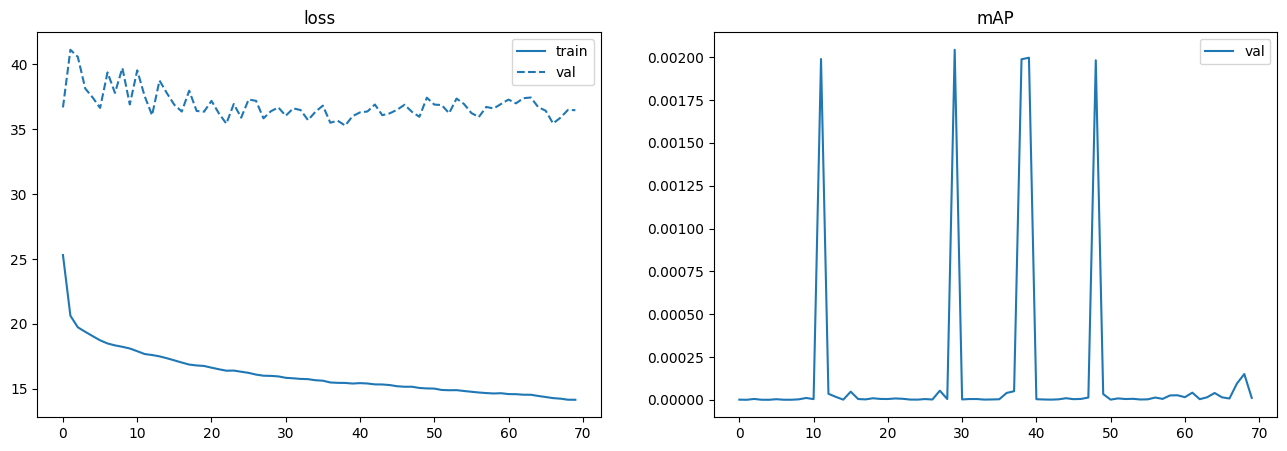

In [45]:
fields_of_interest = ('loss', 'mAP')

plot_logs(log_directory, fields_of_interest)

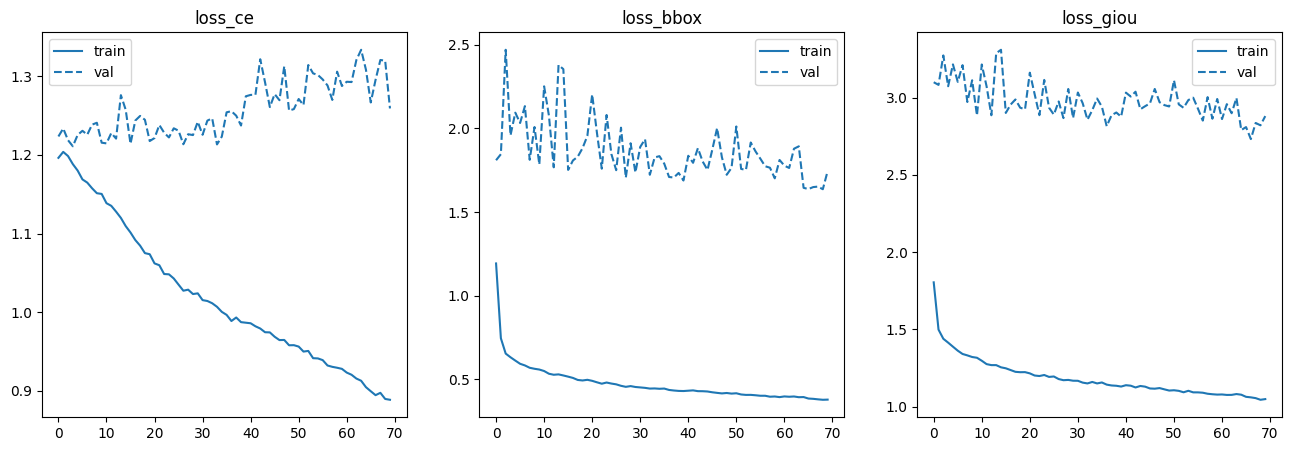

In [46]:
fields_of_interest = ('loss_ce', 'loss_bbox', 'loss_giou')

plot_logs(log_directory, fields_of_interest)

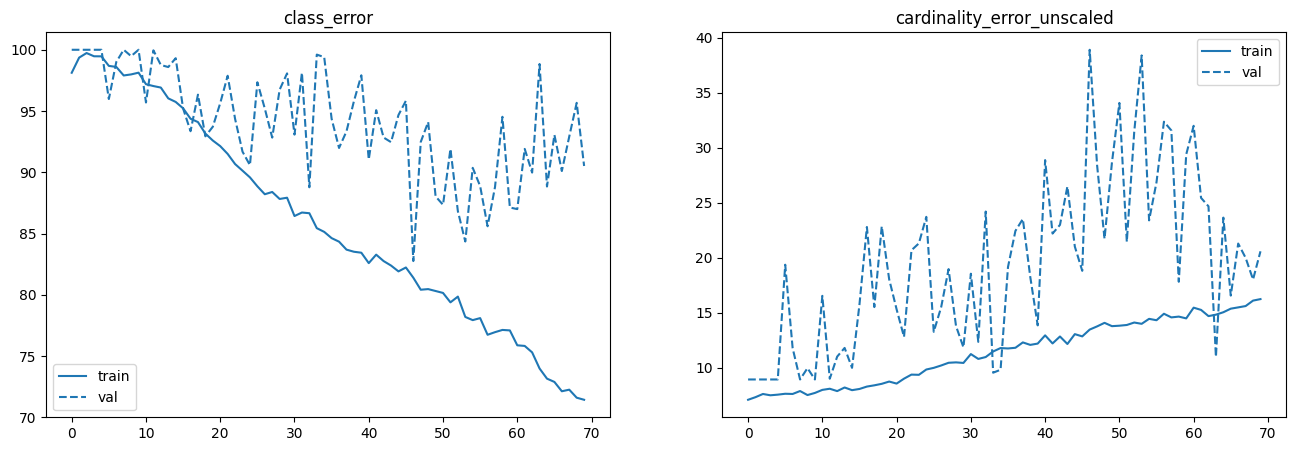

In [47]:
fields_of_interest = ('class_error', 'cardinality_error_unscaled')

plot_logs(log_directory, fields_of_interest)

### Load the fine-tuned model

- How to replace the classification head: https://github.com/facebookresearch/detr/issues/9#issuecomment-636391562

In [27]:
model = torch.hub.load('facebookresearch/detr',
                       'detr_resnet50',
                       pretrained=False,
                       num_classes=num_classes)

checkpoint = torch.load('outputs-low-lr-shape-conv/checkpoint.pth',
                        map_location='cpu')

model.load_state_dict(checkpoint['model'], strict=False)

model.eval();

AttributeError: 'dict' object has no attribute 'eval'

### Boilerplate functions to display fine-tuned results

In [ ]:
def plot_finetuned_results(pil_img, prob=None, boxes=None):
    plt.figure(figsize=(16,10))
    plt.imshow(pil_img)
    ax = plt.gca()
    colors = COLORS * 100
    if prob is not None and boxes is not None:
      for p, (xmin, ymin, xmax, ymax), c in zip(prob, boxes.tolist(), colors):
          ax.add_patch(plt.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin,
                                    fill=False, color=c, linewidth=3))
          cl = p.argmax()
          text = f'{finetuned_classes[cl]}: {p[cl]:0.2f}'
          ax.text(xmin, ymin, text, fontsize=15,
                  bbox=dict(facecolor='yellow', alpha=0.5))
    plt.axis('off')
    plt.show()

In [ ]:
def run_worflow(my_image, my_model):
  # mean-std normalize the input image (batch-size: 1)
  img = transform(my_image).unsqueeze(0)

  # propagate through the model
  outputs = my_model(img)

  for threshold in [0.9, 0.7]:
    print(f'Using bounding box threshold: {threshold}')
    probas_to_keep, bboxes_scaled = filter_bboxes_from_outputs(outputs,
                                                              threshold=threshold)

    plot_finetuned_results(my_image, probas_to_keep, bboxes_scaled)

In [ ]:
import random

def select_random_number_from_file(file_path):
    """Read numbers as strings from a text file and return a random one."""
    with open(file_path, 'r') as file:
        numbers = [line.strip() for line in file if line.strip().isdigit()]
    if numbers:
        return random.choice(numbers)
    else:
        raise ValueError("No valid numbers found in the file.")

In [ ]:
annFile = '{}/lidar/training/label_2_coco/custom_complete.json'.format(dataset_dir)
# initialize COCO api for instance annotations
coco = COCO(annFile)

def show_img_annotations(number):
    # display img annotations
    img = coco.loadImgs(int(random_number))[0]
    annIds = coco.getAnnIds(imgIds=img['id'])
    anns = coco.loadAnns(annIds)
    I = io.imread(img_name)
    plt.imshow(I)
    coco.showAnns(anns, draw_bbox=True)

### With a training image

In [ ]:
from PIL import Image

random_number = select_random_number_from_file(train_txt_path)
print(f'Random train image selected: {random_number}')
img_path = f'/home/matthijs/Documents/study/CS4245_Vision/view-of-delft-dataset/train2017/{random_number}.npy'
rgbd_array = np.load(img_path)
rgb_array = rgbd_array[:, :, :3]
im = Image.fromarray(rgb_array.astype('uint8'))

show_img_annotations(random_number)

# display model predictions for multiple thresholds
run_worflow(im, model)

### With a validation image

In [ ]:
random_number = select_random_number_from_file(val_txt_path)
print(f'Random validation image selected: {random_number}')
img_name = f'/home/matthijs/Documents/study/CS4245_Vision/view-of-delft-dataset/val2017/{random_number}.jpg'
im = Image.open(img_name)

show_img_annotations(random_number)

run_worflow(im, model)

### With an unseen test image

In [ ]:
random_number = select_random_number_from_file(test_txt_path)
print(f'Random test image selected: {random_number}')
img_name = f'/home/matthijs/Documents/study/CS4245_Vision/view-of-delft-dataset/lidar/testing/image_2/{random_number}.jpg'
im = Image.open(img_name)

run_worflow(im, model)

### Inference time

In [ ]:
device = torch.device("cuda")
model.to(device)
img = transform(im).unsqueeze(0).to(device)
dummy_input = torch.randn(1, 3,800,1273, dtype=torch.float).to(device)

In [ ]:
# INIT LOGGERS
starter, ender = torch.cuda.Event(enable_timing=True), torch.cuda.Event(enable_timing=True)
repetitions = 300
timings=np.zeros((repetitions,1))
#GPU-WARM-UP
for _ in range(10):
    _ = model(img)
# MEASURE PERFORMANCE
with torch.no_grad():
    for rep in range(repetitions):
        starter.record()
        _ = model(img)
        ender.record()
        # WAIT FOR GPU SYNC
        torch.cuda.synchronize()
        curr_time = starter.elapsed_time(ender)
        timings[rep] = curr_time

mean_syn = np.sum(timings) / repetitions
std_syn = np.std(timings)
print(f'Inference time: {round(mean_syn/1000, 4)}')
print(f'FPS possible: {round(1000/mean_syn, 1)}')